**Choose dataset**

In [109]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import time

# Load Dataset
df = pd.read_csv('./dataset.txt', header=None)
df = df.rename(columns={10: 'y'})
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,15,70,39,-970,0,0,0,0,0,0,0
1,31,70,39,-970,0,0,0,0,0,0,0
2,46,60,49,-960,0,0,0,0,0,0,0
3,62,60,49,-960,0,0,0,0,0,0,0
4,78,50,39,-960,0,0,0,0,0,0,0


In [107]:
# Remove values annotated with 0 (not part of the experiment)
# Set class for anomalies to 1 and for other samples 0

df.drop(df[df.y == 0].index, inplace = True)
df['y'].replace(to_replace=[1], value=0, inplace=True)
df['y'].replace(to_replace=[2], value=1, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()
print(len(df))

,0,1,2,3,4,5,6,7,8,9,y
0,750000,-30,990,326,-45,972,181,-38,1000,29,0
1,750015,-30,1000,356,-18,981,212,-48,1028,29,0
2,750031,-20,990,336,18,981,222,-38,1038,9,0
3,750046,-20,1000,316,36,990,222,-19,1038,9,0
4,750062,0,990,316,36,990,212,-29,1038,29,0


#*Second Dataset*

In [129]:
# Load second dataset

df = pd.read_csv('./dataset2.arff', header=None)
df = df.rename(columns={14: 'y'})
df.insert(loc=0, column='id', value=0)
df.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,y
0,0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,0,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,0,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,0,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,0,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


# Dataset preprocessing

In [130]:
# Create training and testing sets

train, test = train_test_split(df, test_size=0.1)

In [131]:
# Select non - seasure points from the training set for the enclosing ball

X = train[train.y == 0]

# Remove generated row names and class column (y)

X.drop(X.columns[0], axis=1, inplace=True)
X.drop(X.columns[len(X.columns)-1], axis=1, inplace=True)

# Normalize data
X = (X - X.min()) / (X.max() -X.min())

# Reset index
X = X.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [132]:
n_samples = len(X)
n_features = len(X.columns)

print(n_samples)

7420


# Random dataset

In [87]:
# Generate random easily separable dataset

X = []
for i in range(7000):
  X.append(np.random.uniform(low = 0, high = 0.7, size=(10,)))

X = pd.DataFrame(X)
n_samples = len(X)
n_features = len(X.columns)

In [88]:
# Generate random testing samples

Y = []
for i in range(3000):
  Y.append(np.random.uniform(low = 0.7, high = 1, size=(10,)))

Y = pd.DataFrame(Y)

#**First algorithm implementation**

In [133]:
# Find the most different row from row 1:

first_row = X.iloc[0].values
max, alpha = 0, 0
for i in range(1, n_samples-1):
  row = X.iloc[i].values
  distance = math.sqrt(sum((row - first_row) ** 2))
  if distance > max:
    max = distance
    alpha = i


# Find the most different row from the minimum:

min_row = X.iloc[alpha].values
max, beta = 0, 0
for i in range(n_samples):
  if i != alpha:
    row = X.iloc[i].values
    distance = math.sqrt(sum((row - min_row) ** 2))
    if distance > max:
      max = distance
      beta = i

print(alpha)
print(beta)

3337
7302


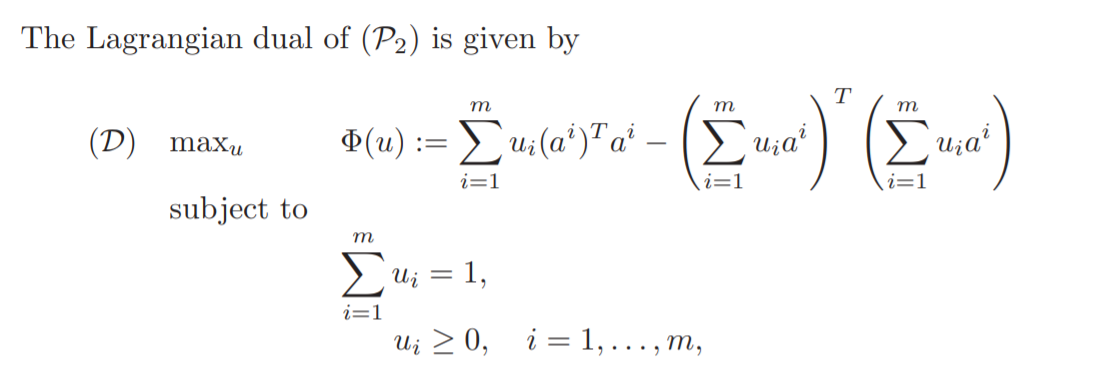

In [134]:
def objective_function(u_vector):
  # Refers to the first term of the equation
  sum = 0

  # Refers to the vector in the second term
  product = np.zeros(n_features)
  for i in range(n_samples):

    # Extract row
    row = X.iloc[i].values

    # Transpose is not needed for vectors multiplication
    sum += u_vector[i] * np.dot(row.T, row)
    product += u_vector[i] * row
    
  return sum - np.dot(product.T, product)

In [135]:
# Initialize vector u 
u = np.zeros(n_samples)
u[alpha] = 0.5
u[beta] = 0.5

a = np.zeros(n_samples)

# Initialize set of current points in ball (min and max)
S = set()
S.add(alpha)
S.add(beta)

# Calculate the ball center - vector of average values among points of size n_features
c = []
for i in range(n_samples):
  c.append(u[i] * X.iloc[i].values)
c = np.average(c, axis=0)

# Initialize gamma vector - calculate objective function
gamma = objective_function(u)

# Calculate k - index of point most distant from the center
max, k = 0, 0
for i in range(n_samples):
    row = X.iloc[i].values
    distance = math.sqrt(sum((row - c) ** 2))
    if distance > max:
      max = distance
      k = i

# Calculate delta value
delta = (math.sqrt(sum((X.iloc[k].values - c) ** 2)) / gamma) - 1
print(math.sqrt(sum((X.iloc[k].values - c) ** 2)))
print(gamma)
print(delta)

2.7608936083814326
2.0078848010537387
0.37502590135276415


In [136]:
# Set threshold
e = 0.01

# Initialize lists for plots
delta_list = []
S_list = []
cpu_time = []

# Set the first iteration at time t = 0
cpu_time.append(0)
delta_list.append(delta)
S_list.append(len(S))

# Start the cpu time clock
t0 = time.perf_counter()

# Loop until delta reaches theshold
while delta > (1 + e) ** 2 - 1:

  # Calculate lambda for iteration
  lambda_ = delta / (2 * (1 + delta))

  # Generate unit vector a
  a = np.zeros(len(a))
  a[k] = 1

  # Update u
  u = (1 - lambda_) * u + lambda_ * a

  # Update c
  c = (1 - lambda_) * c + lambda_ * X.iloc[k].values

  # Add point to the set of points in the ball
  S.add(k)

  # Calculate objective function
  gamma = objective_function(u)

  # Calculate k - index of point most distant from the center
  max, k = 0, 0
  for i in range(n_samples):
      row = X.iloc[i].values
      distance = math.sqrt(sum((row - c) ** 2))
      if distance > max:
        max = distance
        k = i

  # Calculate delta value
  delta = math.sqrt(sum((X.iloc[k].values - c) ** 2)) / gamma - 1
  print(delta)

  # Plot delta and S
  delta_list.append(delta)
  S_list.append(len(S))

  # Calculate CPU time
  t1 = time.perf_counter()
  cpu_time.append(t1 - t0)

radius = math.sqrt((1 + delta) * gamma)

print('Core set:')
print(S)
print('Center: ')
print(c)
print('Radius: ')
print(radius)

0.21001549941345998
0.16039918082843152
-0.005800085569916069
Core set:
{3337, 5892, 7302}
Center: 
[0.19681069 0.06912341 0.12817057 0.19676269 0.19680717 0.00296108
 0.19676283 0.10683192 0.23532585 0.06915859 0.24254153 0.26094937
 0.14164872 0.03300058]
Radius: 
1.4682897990942334


In [137]:
# Create the test data

Y = train[train.y == 1]

# Remove generated row names and class column (y)

Y.drop(Y.columns[0], axis=1, inplace=True)
Y.drop(Y.columns[len(Y.columns)-1], axis=1, inplace=True)

# Normalize data
Y = (Y - Y.min()) / (Y.max() - Y.min())

Y.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000299,0.063667,0.021142,0.047586,0.032695,0.880255,0.958352,0.281039,0.000192,0.793954,0.031620,0.957238,0.000652,0.155071
1,0.000254,0.039552,0.017873,0.038897,0.010750,0.865751,0.948497,0.207583,0.000171,0.727371,0.016380,0.955054,0.000479,0.110669
2,0.000387,0.059484,0.024983,0.036253,0.021945,0.872996,0.956137,0.281039,0.000188,0.786433,0.027998,0.959427,0.000597,0.153740
3,0.000709,0.089393,0.025946,0.073640,0.033140,0.846152,0.952932,0.086094,0.000118,0.827883,0.040571,0.970357,0.001089,0.288936
4,0.000264,0.049195,0.017296,0.033609,0.018810,0.869373,0.946772,0.255714,0.000163,0.728645,0.010474,0.952382,0.000507,0.120606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6057,0.000361,0.085850,0.027674,0.069112,0.026425,0.879534,0.961557,0.205065,0.000108,0.717327,0.022286,0.963070,0.000344,0.148442
6058,0.000341,0.061735,0.019987,0.034744,0.023290,0.868652,0.945541,0.230389,0.000157,0.795228,0.029714,0.961370,0.000670,0.165667
6059,0.000264,0.056914,0.018833,0.045318,0.021500,0.880255,0.961063,0.253147,0.000176,0.777639,0.022286,0.951653,0.000555,0.120606
6060,0.000232,0.069134,0.012683,0.036636,0.019710,0.874453,0.942581,0.220270,0.000192,0.758801,0.024570,0.947763,0.000670,0.091453


In [138]:
# Test accuracy on new points

detected_test = 0

for i  in range(len(Y)):
  dist = math.sqrt(sum((Y.iloc[i].values - c) ** 2))
  if dist > radius:
    detected_test += 1

print(detected_test / len(Y))

1.0


In [139]:
# Test if all training points are in the ball

in_ball = 0

for i  in range(len(X)):
  dist = math.sqrt(sum((X.iloc[i].values - c) ** 2))
  if dist < radius:
    in_ball += 1

print(in_ball / len(X))

0.9995956873315364


In [140]:
# Check if test points are in the ball

# Create the test data

M = test[test.y == 0]

# Remove generated row names and class column (y)

M.drop(M.columns[0], axis=1, inplace=True)
M.drop(M.columns[len(M.columns)-1], axis=1, inplace=True)

# Normalize data
M = (M - M.min()) / (M.max() - M.min())

M.reset_index(drop=True)

in_ball = 0

for i  in range(len(M)):
  dist = math.sqrt(sum((M.iloc[i].values - c) ** 2))
  if dist < radius:
    in_ball += 1

print(in_ball / len(M))

0.9414575866188769


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# **Second algorithm implementation**

In [141]:

# Find the most different row from row 1:

first_row = X.iloc[0].values
max, alpha = 0, 0
for i in range(1, n_samples-1):
  row = X.iloc[i].values
  distance = math.sqrt(sum((row - first_row) ** 2))
  if distance > max:
    max = distance
    alpha = i


# Find the most different row from the minimum:

min_row = X.iloc[alpha].values
max, beta = 0, 0
for i in range(n_samples):
  if i != alpha:
    row = X.iloc[i].values
    distance = math.sqrt(sum((row - min_row) ** 2))
    if distance > max:
      max = distance
      beta = i

print(alpha)
print(beta)

3337
7302


In [144]:
# Initialize vector u 
u = np.zeros(n_samples)
u[alpha] = 0.5
u[beta] = 0.5

# Initialize set of current points in ball (min and max)
S = set()
S.add(alpha)
S.add(beta)

# Calculate the ball center - vector of average values among points of size n_features
c = []
for i in range(n_samples):
  c.append(u[i] * X.iloc[i].values)
c = np.average(c, axis=0)

# Initialize gamma vector - calculate objective function
gamma = objective_function(u)

# Calculate k - index of point most distant from the center
max, k = 0, 0
for i in range(n_samples):
    row = X.iloc[i].values
    distance = math.sqrt(sum((row - c) ** 2))
    if distance > max:
      max = distance
      k = i

# Calculate ksi - index of point closest to the center
# out of all points in the core set

ksi = alpha
min = math.sqrt(sum((X.iloc[alpha].values - c) ** 2))
for i in S:
    row = X.iloc[i].values
    distance = math.sqrt(sum((row - c) ** 2))
    if distance < min:
      min = distance
      ksi = i

# Calculate delta+
delta_plus = (math.sqrt(sum((X.iloc[k].values - c) ** 2)) / gamma) - 1

# Calculate delta-
delta_minus = 1 - (math.sqrt(sum((X.iloc[ksi].values - c) ** 2)) / gamma)

# Calculate delta
delta = delta_plus if delta_plus > delta_minus else delta_minus

print(gamma)
print(delta_plus)
print(delta_minus)

2.0078848010537387
0.37502590135276415
-0.0799219842537855


In [145]:
# Set threshold
e = 0.1

# Initialize lists for plots
delta_list_2 = []
S_list_2 = []
cpu_time_2 = []

# Set the first iteration at time t = 0
cpu_time_2.append(0)
delta_list_2.append(delta)
S_list_2.append(len(S))

# Start the cpu time clock
t0 = time.perf_counter()

# Loop until delta reaches theshold
while delta > (1 + e) ** 2 - 1:

  if delta > delta_minus:

    # Calculate lambda
    lambda_ = delta / (2 * (1 + delta))

    # Generate unit vector a (reffered to as e in the pseudocode)
    a = np.zeros(n_samples)
    a[k] = 1

    # Update u
    u = (1 - lambda_) * u + lambda_ * a

    # Update c
    c = (1 - lambda_) * c + lambda_ * X.iloc[k].values

    # Add point to the set of points in the ball
    S.add(k)
    
  else:
    term_1 = delta_minus / (2  * (1 - delta_minus))
    term_2 = u[ksi] / (1 - u[ksi])

    lambda_ = term_1 if term_1 < term_2 else term_2

    if lambda_ == term_2:
      if ksi in S:
        S.remove(ksi)

    # Generate unit vector a (reffered to as e in the pseudocode)
    a = np.zeros(n_samples)
    a[ksi] = 1

    # Update u
    u = (1 + lambda_) * u - lambda_ * a

    # Update c
    c = (1 + lambda_) * c - lambda_ * X.iloc[ksi].values
    

  # Calculate objective function
  gamma = objective_function(u)

  # Calculate k - index of point most distant from the center
  max, k = 0, 0
  for i in range(n_samples):
      row = X.iloc[i].values
      distance = math.sqrt(sum((row - c) ** 2))
      if distance > max:
        max = distance
        k = i

  # Calculate ksi - index of point closest to the center
  # out of all points in the core set S

  ksi = list(S).pop()
  min = math.sqrt(sum((X.iloc[ksi].values - c) ** 2))
  for i in S:
      row = X.iloc[i].values
      distance = math.sqrt(sum((row - c) ** 2))
      if distance < min:
        min = distance
        ksi = i

  # Calculate delta+
  delta_plus = (math.sqrt(sum((X.iloc[k].values - c) ** 2)) / gamma) - 1

  # Calculate delta-
  delta_minus = 1 - (math.sqrt(sum((X.iloc[ksi].values - c) ** 2)) / gamma)

  # Calculate delta
  delta = delta_plus if delta_plus > delta_minus else delta_minus

  print(delta)
  print(S)

  # Plot delta and core set
  delta_list_2.append(delta)
  S_list_2.append(len(S))

  # Calculate CPU time
  t1 = time.perf_counter()
  cpu_time_2.append(t1 - t0)

radius = math.sqrt((1 + delta) * gamma)

print('Core set:')
print(S)
print('Center: ')
print(c)
print('Radius: ')
print(radius)

0.21001549941345998
{3337, 7302}
0.16039918082843152
{3337, 7302}
Core set:
{3337, 7302}
Center: 
[2.11422933e-01 1.03343363e-05 6.34414553e-02 2.11371366e-01
 2.11419147e-01 3.18092471e-03 2.11371521e-01 4.05185157e-02
 2.11371260e-01 4.81244661e-05 2.11371260e-01 2.06078440e-01
 1.52165447e-01 3.54507122e-02]
Radius: 
1.4919461286753348


**Testing accuracy**

In [146]:
# Create the test data

Y = df[df.y == 1]

# Remove generated row names and class column (y)

Y.drop(Y.columns[0], axis=1, inplace=True)
Y.drop(Y.columns[len(Y.columns)-1], axis=1, inplace=True)

# Normalize data
Y = (Y - Y.min()) / (Y.max() - Y.min())

Y.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000807,0.070420,0.030174,0.046452,0.013440,0.834534,0.956877,0.301279,0.000312,0.878126,0.069141,0.991496,0.002030,0.394985
1,0.000785,0.062701,0.028251,0.045694,0.009859,0.831633,0.953672,0.298761,0.000292,0.876877,0.070096,0.994168,0.002037,0.387064
2,0.000765,0.058199,0.025946,0.041916,0.004480,0.822930,0.950222,0.263316,0.000216,0.834154,0.064380,0.991738,0.001933,0.370552
3,0.000748,0.053058,0.025755,0.035878,0.000899,0.810591,0.948992,0.200030,0.000155,0.793954,0.061906,0.987853,0.001849,0.366585
4,0.000746,0.051446,0.027292,0.036636,0.004034,0.812048,0.950222,0.134176,0.000129,0.785160,0.063429,0.988824,0.001853,0.369882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718,0.000269,0.053058,0.012492,0.043050,0.021054,0.866472,0.955642,0.286074,0.000212,0.751255,0.015047,0.952866,0.000562,0.121534
6719,0.000256,0.054017,0.012300,0.038521,0.020155,0.867916,0.954902,0.265834,0.000178,0.741212,0.011808,0.948251,0.000541,0.112286
6720,0.000257,0.053377,0.012878,0.040789,0.020600,0.867916,0.954657,0.275954,0.000175,0.729894,0.011046,0.947522,0.000552,0.120220
6721,0.000281,0.054017,0.014605,0.046828,0.021500,0.869373,0.958352,0.301279,0.000200,0.747483,0.012952,0.951894,0.000583,0.134748


In [147]:
# Test accuracy on new points

detected_test = 0

for i  in range(len(Y)):
  dist = math.sqrt(sum((Y.iloc[i].values - c) ** 2))
  if dist > radius:
    detected_test += 1

print(detected_test / len(Y))

1.0


In [148]:
# Test if all training points are in the ball

in_ball = 0

for i  in range(len(X)):
  dist = math.sqrt(sum((X.iloc[i].values - c) ** 2))
  if dist < radius:
    in_ball += 1

print(in_ball / len(X))

0.9995956873315364


In [149]:
# Check if test points are in the ball

# Create the test data

M = test[test.y == 0]

# Remove generated row names and class column (y)

M.drop(M.columns[0], axis=1, inplace=True)
M.drop(M.columns[len(M.columns)-1], axis=1, inplace=True)

# Normalize data
M = (M - M.min()) / (M.max() - M.min())

M.reset_index(drop=True)

in_ball = 0

for i  in range(len(M)):
  dist = math.sqrt(sum((M.iloc[i].values - c) ** 2))
  if dist < radius:
    in_ball += 1

print(in_ball / len(M))

0.9354838709677419


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [150]:
# Check if test points are in the ball

# Create the test data

N = test[test.y == 1]

# Remove generated row names and class column (y)

N.drop(N.columns[0], axis=1, inplace=True)
N.drop(N.columns[len(N.columns)-1], axis=1, inplace=True)

# Normalize data
N = (N - N.min()) / (N.max() - N.min())

N.reset_index(drop=True)

out_ball = 0

for i  in range(len(N)):
  dist = math.sqrt(sum((N.iloc[i].values - c) ** 2))
  if dist > radius:
    out_ball += 1

print(out_ball / len(N))

0.09984871406959153


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Results and plots

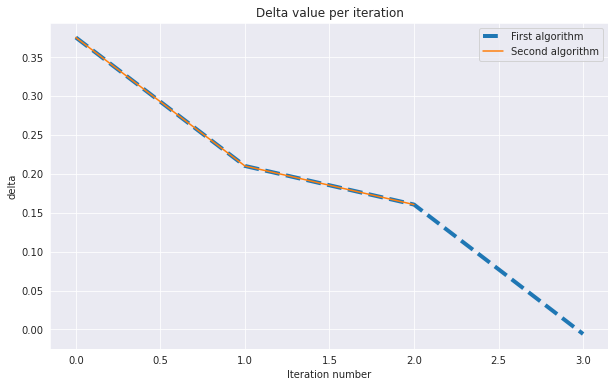

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,6)


# Delta value plots 

plt.plot(delta_list,'--', linewidth=4)
plt.plot(delta_list_2)
plt.legend(['First algorithm', 'Second algorithm'])
plt.xlabel('Iteration number')
plt.ylabel('delta')
plt.title('Delta value per iteration')
plt.savefig('dataset-2-delta.png')
plt.show()

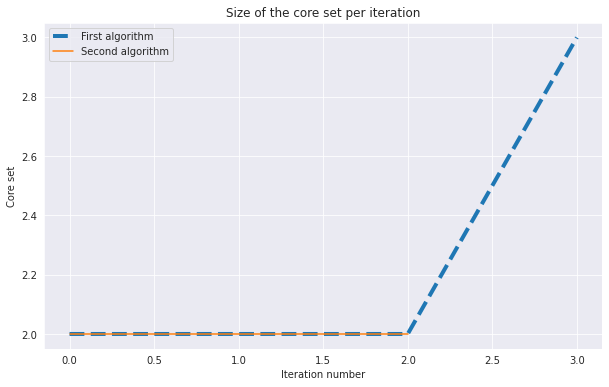

In [153]:
# Core set plots 

plt.plot(S_list,'--', linewidth=4)
plt.plot(S_list_2)
plt.legend(['First algorithm', 'Second algorithm'])
plt.xlabel('Iteration number')
plt.ylabel('Core set')
plt.title('Size of the core set per iteration')
plt.savefig('dataset-2-S.png')
plt.show()

Text(0.5, 1.0, 'Delta value over CPU time')

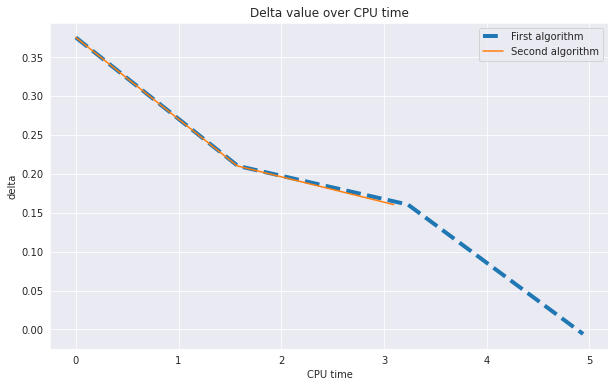

In [154]:
# Delta over CPU plots

plt.plot(cpu_time, delta_list, '--', linewidth=4)
plt.plot(cpu_time_2, delta_list_2)
plt.legend(['First algorithm', 'Second algorithm'])
plt.xlabel('CPU time')
plt.ylabel('delta')
plt.savefig('dataset-2-delta-cpu.png')
plt.title('Delta value over CPU time')

Text(0.5, 1.0, 'Core set size over CPU time')

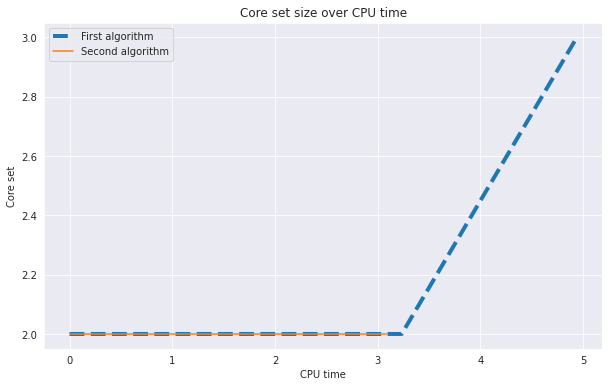

In [155]:
# Core set over CPU plots

plt.plot(cpu_time, S_list, '--', linewidth=4)
plt.plot(cpu_time_2, S_list_2)
plt.legend(['First algorithm', 'Second algorithm'])
plt.xlabel('CPU time')
plt.ylabel('Core set')
plt.savefig('dataset-2-S-cpu.png')
plt.title('Core set size over CPU time')